# 本节需要用到的函数



In [ ]:
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [ ]:
def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        it.iternext()   
        
    return grad

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        # 对应张量
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax的输出
        self.t = None # 监督数据

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [ ]:
import numpy as np

def smooth_curve(x):
    """用于使损失函数的图形变圆滑

    参考：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]



In [ ]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
from IPython.terminal.embed import InteractiveShellEmbed
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

## if you run in terminal, run this
# dataset_dir = os.path.dirname(os.path.abspath(__file__))
## if you run in IPython, run this
ip_shell = InteractiveShellEmbed()
dataset_dir = ip_shell.magic("%pwd")

save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """读入MNIST数据集
    
    Parameters
    ----------
    normalize : 将图像的像素值正规化为0.0~1.0
    one_hot_label : 
        one_hot_label为True的情况下，标签作为one-hot数组返回
        one-hot数组是指[0,0,1,0,0,0,0,0,0,0]这样的数组
    flatten : 是否将图像展开为一维数组
    
    Returns
    -------
    (训练图像, 训练标签), (测试图像, 测试标签)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


# 参数的更新

## 随机梯度下降 SGD


$$
\newcommand{\bd}{\boldsymbol}
$$

深度学习的目的就是找到令损失函数最小的参数，找最优参数的过程称为 **最优化（optimization）**。前面的最优化使用的是梯度下降的方法，由于我们一开始的参数初始值是随机的，所以又称 **随机梯度下降法（SGD，Stochastic Gradient Descent）**。SGD用数学表示为：

$$
\bd{W} \leftarrow \bd{W} - \eta \frac{\partial L}{\partial \bd{W}}\\
\bd{W}：权重 \quad \eta：学习率 \quad L：损失函数
$$

In [ ]:
import numpy as np

class SGD:

    """随机梯度下降法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

但SGD有个缺点。比如我们考虑求函数 $f(x,y)=\frac{1}{20} x^2 + y^2$ 的最小值，如下图所示：



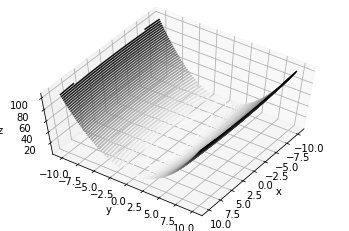

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, y):
    return x**2 / 20.0 + y**2
x = np.linspace(-10,10,30)
y = np.linspace(-10,10,30)
X, Y = np.meshgrid(x, y)
Z = f(X,Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#调整观察角度和方位角。这里将俯仰角设为60度，把方位角调整为35度
ax.view_init(60, 35)

从图中可以看出，这个函数的梯度并不是均匀的，而是在y轴方向大，在x轴方向小。如果我们从边上的某个点出发，利用SGD去寻找最小值，那么我们就会发现寻找的过程是这样的：

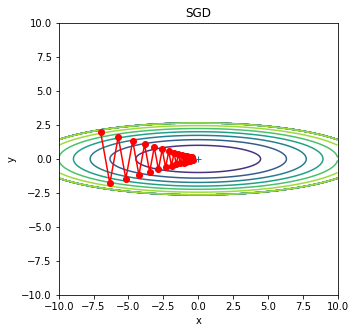

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
#optimizers["Momentum"] = Momentum(lr=0.1)
#optimizers["AdaGrad"] = AdaGrad(lr=1.5)
#optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    #plt.subplot(2, 2, idx)
    #idx += 1
    plt.figure(figsize=(5,5))
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

图中，SGD的路径呈“之”字形，非常低效。因此，如果函数的形状非均向（**anisotropic**），那么梯度的方向就不是指向最小值，搜索效率会很低。

## Momentum SGD

Momentum 表示动量，其原理就和物理世界一样，想象有个小球从最高点滑到最低点，小球在下降的过程中，会带有一定动量，从而其轨迹并不是沿梯度下降的方向，而是在动量惯性的作用下接近最低点。

用数学方法表示如下：

$$
\bd{v} \leftarrow \alpha \bd{v} -\eta \frac{\partial L}{\partial \bd{W}}\\
\bd{W} \leftarrow \bd{W} + \bd{v}
$$

这里引入的速度 $\bd{v}$，参数会向速度方向更新，同时，之前的动量也会影响速度，所以有 $\alpha \bd{v}$ 项，由于动量会因为摩擦力等因素而减小，所以 $\alpha<1$。

In [ ]:
class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

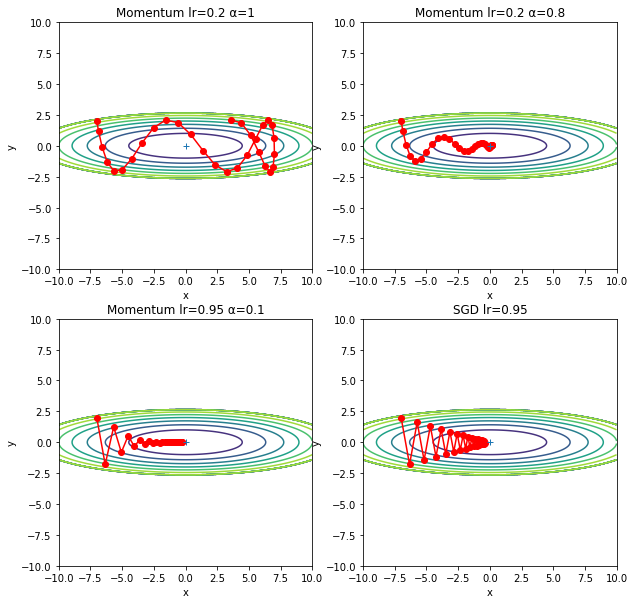

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
#optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum lr=0.2 α=1"] = Momentum(lr=0.2, momentum=1)
optimizers["Momentum lr=0.2 α=0.8"] = Momentum(lr=0.2, momentum=0.8)
optimizers["Momentum lr=0.95 α=0.1"] = Momentum(lr=0.95, momentum=0.1)
optimizers["SGD lr=0.95"] = SGD(lr=0.95)
#optimizers["AdaGrad"] = AdaGrad(lr=1.5)
#optimizers["Adam"] = Adam(lr=0.3)

idx = 1

plt.figure(figsize=(10,10))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    #plt.figure(figsize=(10,10))
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

上图展示了在摩擦力 $\alpha$ 取不同值的情况下的搜索路径，以及与 SGD 的比较。可以很明显的看出， $\alpha$ 过大的话，惯性太强，会导致错过最低点，而如果 $\alpha$ 过小，就会导致摩擦力过小，从而退化成 SGD。

当 $\alpha$ 取值适中时，路径就像小球滑动一样，由于在y轴方向上速度相互抵消，x轴方向上速度则累积，所以路径有向 x 方向靠近的趋势。

这里要说明一下，图中几种方法的学习率并不完全一样。学习率一样的图如下：

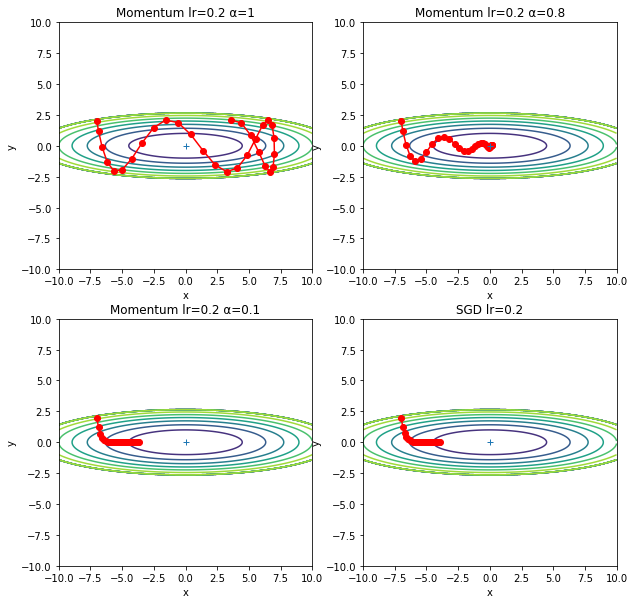

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
#optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum lr=0.2 α=1"] = Momentum(lr=0.2, momentum=1)
optimizers["Momentum lr=0.2 α=0.8"] = Momentum(lr=0.2, momentum=0.8)
optimizers["Momentum lr=0.2 α=0.1"] = Momentum(lr=0.2, momentum=0.1)
optimizers["SGD lr=0.2"] = SGD(lr=0.2)
#optimizers["AdaGrad"] = AdaGrad(lr=1.5)
#optimizers["Adam"] = Adam(lr=0.3)

idx = 1

plt.figure(figsize=(10,10))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    #plt.figure(figsize=(10,10))
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## AdaGrad

AdaGrad 全称是 Adaptive Gradient，这种方法就是适当的调整学习率，使得学习率随着学习不断减小。用数学表示为：

$$
\bd{h} \leftarrow \bd{h} + \frac{\partial L}{\partial \bd{W}} \odot \frac{\partial L}{\partial \bd{W}}\\
\bd{W} \leftarrow \bd{W} - \eta \frac{1}{\sqrt{\bd{h}}} \frac{\partial L}{\partial \bd{W}}
$$

$\odot$ 表示矩阵的对应元素相乘。$\bd{h}$ 会记录过去所有梯度的平方和，显然学习的次数越多，$\bd{h}$ 越大，则 $\eta \frac{1}{\sqrt{\bd{h}}}$ 越小。

In [ ]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) #1e-7 是为了避免出现除以0的情况

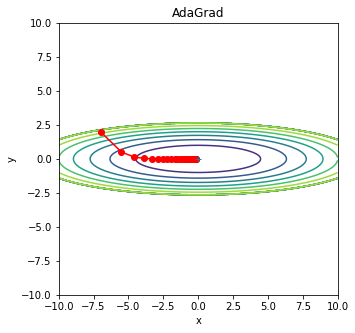

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
#optimizers["SGD"] = SGD(lr=0.95)
#optimizers["Momentum lr=0.2 α=1"] = Momentum(lr=0.2, momentum=1)
#optimizers["Momentum lr=0.2 α=0.8"] = Momentum(lr=0.2, momentum=0.8)
#optimizers["Momentum lr=0.2 α=0.1"] = Momentum(lr=0.2, momentum=0.1)
#optimizers["SGD lr=0.2"] = SGD(lr=0.2)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
#optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    #plt.subplot(2, 2, idx)
    #idx += 1
    plt.figure(figsize=(5,5))
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## 其他方法

Adma 将 Momentum 和 AdaGrad 结合在一起，同时加入超参数的“偏置校正”。但其代码有段复杂，在此不做解释。

In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

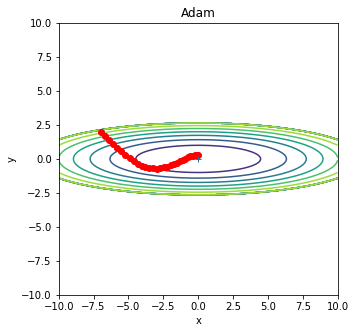

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
#optimizers["SGD"] = SGD(lr=0.95)
#optimizers["Momentum lr=0.2 α=0.8"] = Momentum(lr=0.2, momentum=0.8)
#optimizers["SGD lr=0.2"] = SGD(lr=0.2)
#optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    #plt.subplot(2, 2, idx)
    #idx += 1
    plt.figure(figsize=(5,5))
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## 四种方法比较

这四种方法各有各的好处，目前大部分还是在用 SGD，很多研究人员也喜欢用 Adam。



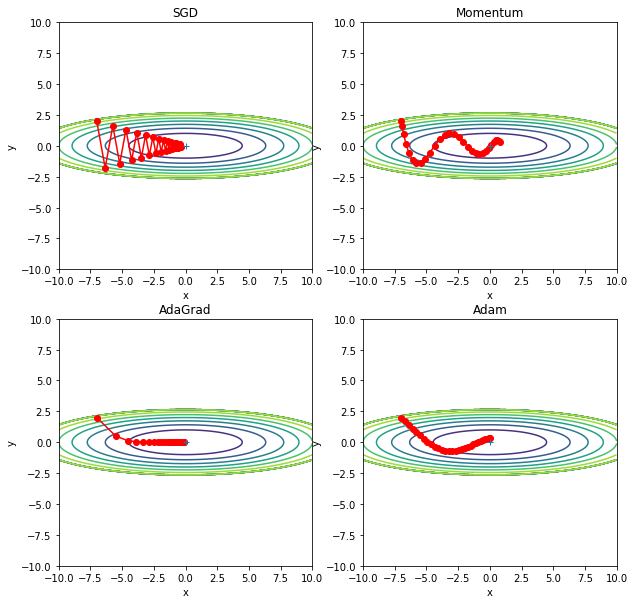

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
plt.figure(figsize=(10,10))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

In [ ]:
import numpy as np
from collections import OrderedDict


class MultiLayerNet:
    """全连接的多层神经网络

    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    weight_decay_lambda : Weight Decay（L2范数）的强度
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 初始化权重
        self.__init_weight(weight_init_std)

        # 生成层
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """设定权重的初始值

        Parameters
        ----------
        weight_init_std : 指定权重的标准差（e.g. 0.01）
            指定'relu'或'he'的情况下设定“He的初始值”
            指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # 使用ReLU的情况下推荐的初始值
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # 使用sigmoid的情况下推荐的初始值

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """求损失函数

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        损失函数的值
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """求梯度（数值微分）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """求梯度（误差反向传播法）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

===========iteration:0===========
SGD:2.3485739917108637
Momentum:2.3522046522492794
AdaGrad:2.09596243880509
Adam:2.286168134839006
===========iteration:100===========
SGD:1.6737021818918079
Momentum:0.34304437641185453
AdaGrad:0.09744134360533335
Adam:0.21940551777853826
===========iteration:200===========
SGD:0.9104381165995677
Momentum:0.1873309205345749
AdaGrad:0.10002099602063744
Adam:0.1292136135227925
===========iteration:300===========
SGD:0.7283782378846393
Momentum:0.3225125565712884
AdaGrad:0.15720771302985487
Adam:0.21638674225543547
===========iteration:400===========
SGD:0.391455496853796
Momentum:0.1029791678320692
AdaGrad:0.058029357107012264
Adam:0.058460664481003934
===========iteration:500===========
SGD:0.35312427699249405
Momentum:0.11811551694219022
AdaGrad:0.05317992225784239
Adam:0.0975733073952009
===========iteration:600===========
SGD:0.3968798142346487
Momentum:0.13257770306109418
AdaGrad:0.04442060488233331
Adam:0.06868626113583051
===========iteration:700

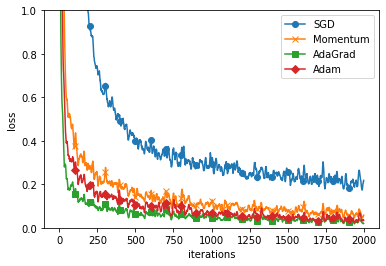

In [ ]:


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 权重的初始值

## 不能将权重初始值设为0

[谈谈神经网络权重为什么不能初始化为0](https://zhuanlan.zhihu.com/p/75879624)



## 隐藏层的激活值分布

隐藏层的激活值指的是激活函数的输出数据。下面来做一个实验，实验过程如下：

1. 构造一个5层神经网络，每个网络有100个节点，参数随机初始化
2. 随机构造1000个数据
3. 将数据输入到网络，看看每层的激活值的分布

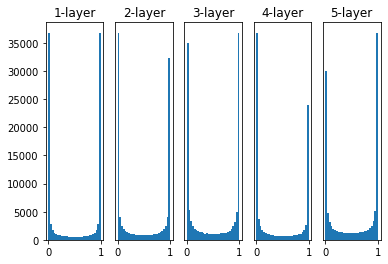

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

当初始化权重采用标准差为1的高斯分布时，由图中可以看出，Sigmoid 函数的输出靠近0和1，回想Sigmoid函数图像的特点，y越是靠近0和1，梯度越小甚至会消失。这个问题称为 **梯度消失**。层次越深，梯度消失问题越严重。

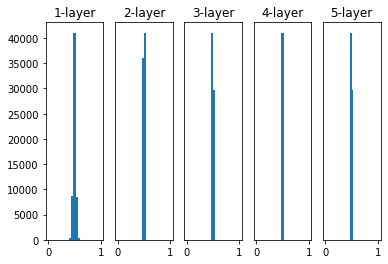

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

如果改为使用标准差为 0.01 的高斯分布，激活值分布如图，集中在 0.5 附近，这说明网络的表现力有很大问题，因为如果多个神经元的输出都差不多，那为什么不用一个神经元代替呢？这样多个神经元就没有意义了。

要设置合适的权重，可以采用 Xavier 等人提出的 Xavier 初始值，即如果前一层的节点数为 $n$，则初始值使用标准差为 $\frac{1}{\sqrt{n}}$ 的分布。

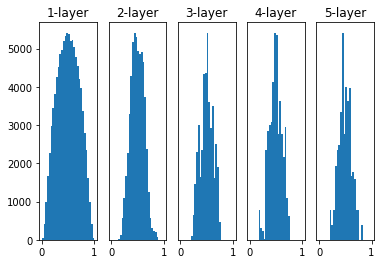

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

可以看出，越是后面的层，图像越是歪斜、集中，但都比前两次实验好，这样 sigmoid 的表现力不受限制，可以进行高效的学习。把激活函数换成 tanh 的话，和 Sigmoid 类似，也是使用 Xavier 初始值。

如果将激活函数换成 ReLU，则推荐使用 He初始值：初始值使用标准差为 $\frac{2}{\sqrt{n}}$ 的分布。直观上可以认为，ReLU 负值区域的值为0，要使其更有广度，需要 2 倍系数。

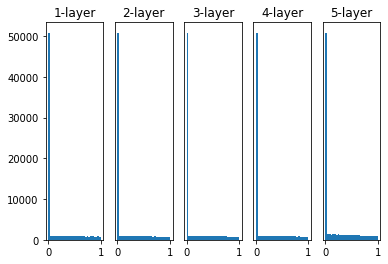

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

下面看看不同初始值的幅值方法在多大程度上影响神经网络的学习：

===========iteration:0===========
std=0.01:2.302488098394867
Xavier:2.313991861232406
He:2.379480621555028
===========iteration:100===========
std=0.01:2.301946884429742
Xavier:2.2759217861258234
He:1.5404494857149582
===========iteration:200===========
std=0.01:2.303139397799229
Xavier:2.191849922446238
He:0.8991489947624611
===========iteration:300===========
std=0.01:2.3040541960447047
Xavier:2.016783792641773
He:0.48854931051925543
===========iteration:400===========
std=0.01:2.3021457045022773
Xavier:1.5923141443350293
He:0.40391016489106313
===========iteration:500===========
std=0.01:2.301867924364439
Xavier:1.087718167226913
He:0.3346890028961583
===========iteration:600===========
std=0.01:2.2981436052064783
Xavier:0.7184081251134143
He:0.26243148305132696
===========iteration:700===========
std=0.01:2.302637321415247
Xavier:0.6704853185787227
He:0.32589530836927005
===========iteration:800===========
std=0.01:2.3015025938329865
Xavier:0.5503642928247523
He:0.2696782240186154


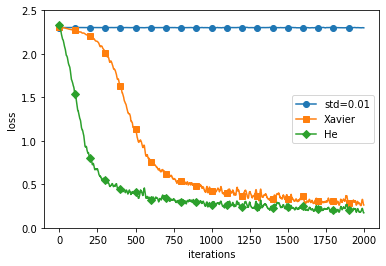

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

可以看出，使用 Xavier 和 He 都能较快收敛，而0.01高斯分布则非常菜……

# Batch Normalization

这是一种比较新的方法（2015年提出），它具有以下优点：

* 可以使学习快速进行
* 不那么依赖初始值
* 抑制过拟合

其原理是这样的：对 mini-batch 的 $m$ 个输入 $\{x_1,x_2,\cdots,x_m\}$ 进行正规化，变换为均值为0，方差为1的数据 $\{\hat{x}_1,\hat{x}_2,\cdots,\hat{x}_m\}$，然后对正规化的数据进行缩放和平移：$y_i \leftarrow \gamma \hat{x}_i+\beta$

正规化的公式如下：

$$
\mu_B \leftarrow \frac{1}{m} \sum_{i=1}^m x_i\\
\sigma_B^2 \leftarrow \frac{1}{m} \sum_{i=1}^m (x_i-\mu_B)^2\\
\hat{x}_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \varepsilon}}
$$

Batch Norm 一般在激活函数前后，可以减小数据分布的偏向。

# 正则化

# 超参数的验证